In [4]:
#one level up into project folder
import os
#os.chdir("..")

#print("Current working directory:", os.getcwd())

In [5]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

import optuna

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# VisionInfantNet utilities
from vocalbaby.utils.ml_utils.metric.classification_metric import get_classification_score

print("Imports completed.")


Imports completed.


In [6]:
import dagshub
dagshub.init(repo_owner="arunps12", repo_name="VisionInfantNet", mlflow=True)

import mlflow
import mlflow.sklearn

print("MLflow + DagsHub initialized.")


Accessing as arunps12

Initialized MLflow to track repo "arunps12/VisionInfantNet"

Repository arunps12/VisionInfantNet initialized!

MLflow + DagsHub initialized.


In [7]:
def get_latest_artifact(root_dir="artifacts"):
    subdirs = [
        os.path.join(root_dir, d)
        for d in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, d))
    ]
    latest = max(subdirs, key=os.path.getmtime)
    print("Latest artifact directory:", latest)
    return latest

latest_artifact_dir = get_latest_artifact()


Latest artifact directory: artifacts/12_06_2025_14_47_14


In [9]:
paths = {
    "egemaps_train": os.path.join(latest_artifact_dir, "data_transformation/features/train_compare_features.npy"),
    "egemaps_valid": os.path.join(latest_artifact_dir, "data_transformation/features/valid_compare_features.npy"),
    "egemaps_test" : os.path.join(latest_artifact_dir, "data_transformation/features/test_compare_features.npy"),

    "y_train": os.path.join(latest_artifact_dir, "data_transformation/features/train_labels.npy"),
    "y_valid": os.path.join(latest_artifact_dir, "data_transformation/features/valid_labels.npy"),
    "y_test" : os.path.join(latest_artifact_dir, "data_transformation/features/test_labels.npy"),
}

for k, v in paths.items():
    print(k, "→", v)


egemaps_train → artifacts/12_06_2025_14_47_14/data_transformation/features/train_compare_features.npy
egemaps_valid → artifacts/12_06_2025_14_47_14/data_transformation/features/valid_compare_features.npy
egemaps_test → artifacts/12_06_2025_14_47_14/data_transformation/features/test_compare_features.npy
y_train → artifacts/12_06_2025_14_47_14/data_transformation/features/train_labels.npy
y_valid → artifacts/12_06_2025_14_47_14/data_transformation/features/valid_labels.npy
y_test → artifacts/12_06_2025_14_47_14/data_transformation/features/test_labels.npy


In [10]:
y_train = np.load(paths["y_train"])
y_valid = np.load(paths["y_valid"])
y_test  = np.load(paths["y_test"])

label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_valid_enc = label_encoder.transform(y_valid)
y_test_enc  = label_encoder.transform(y_test)

class_names = list(label_encoder.classes_)

print("Label encoding mapping:")
for org, enc in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{org} → {enc}")


Label encoding mapping:
Canonical → 0
Crying → 1
Junk → 2
Laughing → 3
Non-canonical → 4


In [11]:
X_train_raw = np.load(paths["egemaps_train"])
X_valid_raw = np.load(paths["egemaps_valid"])
X_test_raw  = np.load(paths["egemaps_test"])

# Fit imputer on TRAIN only
imputer = SimpleImputer(strategy="median")
X_train_egemaps = imputer.fit_transform(X_train_raw)
X_valid_egemaps = imputer.transform(X_valid_raw)
X_test_egemaps  = imputer.transform(X_test_raw)

print("eGeMAPS TRAIN:", X_train_egemaps.shape)
print("eGeMAPS DEV:", X_valid_egemaps.shape)
print("eGeMAPS TEST:", X_test_egemaps.shape)


eGeMAPS TRAIN: (3600, 88)
eGeMAPS DEV: (3580, 88)
eGeMAPS TEST: (3590, 88)


In [32]:
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_egemaps, y_train_enc)

print("After SMOTE distribution:", dict(Counter(y_train_sm)))


After SMOTE distribution: {np.int64(1): 1437, np.int64(3): 1437, np.int64(0): 1437, np.int64(4): 1437, np.int64(2): 1437}


In [13]:
def objective(trial):

    # Hyperparameter search space
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1500),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
    }

    model = XGBClassifier(
        **params,
        objective="multi:softprob",
        eval_metric="mlogloss",
        tree_method="hist",
        random_state=42,
        n_jobs=-1,
    )

    # Train on SMOTE TRAIN
    model.fit(X_train_sm, y_train_sm)

    # Predict on DEV
    y_dev_pred = model.predict(X_valid_egemaps)

    # VINF metrics
    metrics = get_classification_score(y_valid_enc, y_dev_pred)

    uar = metrics.uar
    f1  = metrics.f1_score

    trial.set_user_attr("UAR", uar)
    trial.set_user_attr("F1", f1)

    print(f"[Trial {trial.number}] UAR={uar:.4f} F1={f1:.4f}")

    return uar, f1


In [14]:
study = optuna.create_study(
    directions=["maximize", "maximize"],
    study_name="xgb_egemaps_smote_optuna",
)

study.optimize(objective, n_trials=40)

print("Optuna tuning completed.")
print("Number of Pareto-optimal trials:", len(study.best_trials))


[I 2025-12-08 13:47:54,825] A new study created in memory with name: xgb_egemaps_smote_optuna
[I 2025-12-08 13:52:45,106] Trial 0 finished with values: [0.43524343427058565, 0.6164952439995828] and parameters: {'max_depth': 12, 'learning_rate': 0.11287566925348573, 'n_estimators': 1246, 'subsample': 0.9057976876909895, 'colsample_bytree': 0.8543453676860666, 'gamma': 0.6212916737114271, 'min_child_weight': 8, 'reg_lambda': 4.860303936508563, 'reg_alpha': 0.7378027995419278}.


[Trial 0] UAR=0.4352 F1=0.6165


[I 2025-12-08 13:56:22,308] Trial 1 finished with values: [0.425734531928658, 0.6168711471821671] and parameters: {'max_depth': 8, 'learning_rate': 0.12601137304867943, 'n_estimators': 1151, 'subsample': 0.7717285097073125, 'colsample_bytree': 0.75383262784564, 'gamma': 0.1505098664146487, 'min_child_weight': 6, 'reg_lambda': 3.748748454912621, 'reg_alpha': 3.4302498937579307}.


[Trial 1] UAR=0.4257 F1=0.6169


[I 2025-12-08 13:57:09,775] Trial 2 finished with values: [0.4527758744599633, 0.5910211754597253] and parameters: {'max_depth': 6, 'learning_rate': 0.2645047187865657, 'n_estimators': 320, 'subsample': 0.708456449189057, 'colsample_bytree': 0.5002451888641862, 'gamma': 3.333257641660956, 'min_child_weight': 5, 'reg_lambda': 1.7881552000678125, 'reg_alpha': 4.32389754227776}.


[Trial 2] UAR=0.4528 F1=0.5910


[I 2025-12-08 13:57:59,033] Trial 3 finished with values: [0.4576752024278249, 0.5927861902562519] and parameters: {'max_depth': 3, 'learning_rate': 0.07103805098153734, 'n_estimators': 946, 'subsample': 0.9475250102535702, 'colsample_bytree': 0.94288712851136, 'gamma': 3.0997637238268383, 'min_child_weight': 4, 'reg_lambda': 4.894966875189016, 'reg_alpha': 4.959905161100508}.


[Trial 3] UAR=0.4577 F1=0.5928


[I 2025-12-08 14:00:13,802] Trial 4 finished with values: [0.4561419094617206, 0.6132354899929601] and parameters: {'max_depth': 4, 'learning_rate': 0.020895824289993474, 'n_estimators': 612, 'subsample': 0.7492677677794406, 'colsample_bytree': 0.5364210391501454, 'gamma': 0.5851115882112662, 'min_child_weight': 1, 'reg_lambda': 1.4580757786517606, 'reg_alpha': 2.0249272705817036}.


[Trial 4] UAR=0.4561 F1=0.6132


[I 2025-12-08 14:00:36,202] Trial 5 finished with values: [0.44106190516112076, 0.6056978685152659] and parameters: {'max_depth': 10, 'learning_rate': 0.14373660929631696, 'n_estimators': 680, 'subsample': 0.8421114343221303, 'colsample_bytree': 0.5933458760367087, 'gamma': 3.7513687097214836, 'min_child_weight': 8, 'reg_lambda': 4.280155901423675, 'reg_alpha': 1.6106474038134522}.


[Trial 5] UAR=0.4411 F1=0.6057


[I 2025-12-08 14:01:21,075] Trial 6 finished with values: [0.44318812475596336, 0.6252948798480737] and parameters: {'max_depth': 8, 'learning_rate': 0.09687593031288332, 'n_estimators': 1485, 'subsample': 0.7920448186017736, 'colsample_bytree': 0.5538035678977202, 'gamma': 1.1556584937753018, 'min_child_weight': 5, 'reg_lambda': 1.6020851869148438, 'reg_alpha': 1.4553986960577792}.


[Trial 6] UAR=0.4432 F1=0.6253


[I 2025-12-08 14:01:30,964] Trial 7 finished with values: [0.4509019928683123, 0.6135706915848607] and parameters: {'max_depth': 9, 'learning_rate': 0.01227158232461289, 'n_estimators': 559, 'subsample': 0.6154671440782015, 'colsample_bytree': 0.7743994427185086, 'gamma': 2.883762847804607, 'min_child_weight': 3, 'reg_lambda': 0.36517410687457175, 'reg_alpha': 1.000865274222524}.


[Trial 7] UAR=0.4509 F1=0.6136


[I 2025-12-08 14:01:43,435] Trial 8 finished with values: [0.45298072099919545, 0.6033769415490459] and parameters: {'max_depth': 11, 'learning_rate': 0.16348658918713652, 'n_estimators': 1477, 'subsample': 0.8333655465130705, 'colsample_bytree': 0.8272912243247019, 'gamma': 4.487850688976912, 'min_child_weight': 9, 'reg_lambda': 4.19914677147718, 'reg_alpha': 2.217920691412637}.


[Trial 8] UAR=0.4530 F1=0.6034


[I 2025-12-08 14:01:49,087] Trial 9 finished with values: [0.45646992635164824, 0.6051648415641008] and parameters: {'max_depth': 12, 'learning_rate': 0.03467527145400466, 'n_estimators': 823, 'subsample': 0.5472296498857837, 'colsample_bytree': 0.5935974689566508, 'gamma': 4.108057672898601, 'min_child_weight': 1, 'reg_lambda': 4.702945365799199, 'reg_alpha': 1.2285573356540125}.


[Trial 9] UAR=0.4565 F1=0.6052


[I 2025-12-08 14:01:50,240] Trial 10 finished with values: [0.45979913180184767, 0.6062461383588842] and parameters: {'max_depth': 3, 'learning_rate': 0.12237629996558716, 'n_estimators': 147, 'subsample': 0.7499792184696984, 'colsample_bytree': 0.6481815730537525, 'gamma': 1.2675170081492348, 'min_child_weight': 8, 'reg_lambda': 3.1505739185590915, 'reg_alpha': 1.6088050209514821}.


[Trial 10] UAR=0.4598 F1=0.6062


[I 2025-12-08 14:01:59,683] Trial 11 finished with values: [0.44805244774563613, 0.6114685178456918] and parameters: {'max_depth': 5, 'learning_rate': 0.01666245042132198, 'n_estimators': 926, 'subsample': 0.7131511035292163, 'colsample_bytree': 0.660839605686444, 'gamma': 1.844521114764957, 'min_child_weight': 6, 'reg_lambda': 0.8613489913617867, 'reg_alpha': 3.873885801623566}.


[Trial 11] UAR=0.4481 F1=0.6115


[I 2025-12-08 14:02:09,070] Trial 12 finished with values: [0.4440382540532199, 0.6053637472391373] and parameters: {'max_depth': 9, 'learning_rate': 0.06227968658535649, 'n_estimators': 172, 'subsample': 0.6098838577112664, 'colsample_bytree': 0.5324329843555452, 'gamma': 1.2527225159837467, 'min_child_weight': 6, 'reg_lambda': 4.778579486125569, 'reg_alpha': 4.916925572075615}.


[Trial 12] UAR=0.4440 F1=0.6054


[I 2025-12-08 14:02:13,168] Trial 13 finished with values: [0.4463496272295086, 0.6060022937596325] and parameters: {'max_depth': 12, 'learning_rate': 0.19298830243137705, 'n_estimators': 594, 'subsample': 0.6789647480009275, 'colsample_bytree': 0.7624815517841326, 'gamma': 2.7400576601310056, 'min_child_weight': 8, 'reg_lambda': 3.270261784590105, 'reg_alpha': 4.12696019780048}.


[Trial 13] UAR=0.4463 F1=0.6060


[I 2025-12-08 14:02:28,116] Trial 14 finished with values: [0.4390742345269313, 0.6076478164582111] and parameters: {'max_depth': 7, 'learning_rate': 0.010049821212686508, 'n_estimators': 919, 'subsample': 0.77274390947383, 'colsample_bytree': 0.8987570476025939, 'gamma': 1.9360429278886904, 'min_child_weight': 5, 'reg_lambda': 4.855687196985276, 'reg_alpha': 2.7610869514203227}.


[Trial 14] UAR=0.4391 F1=0.6076


[I 2025-12-08 14:02:39,726] Trial 15 finished with values: [0.4461277366220246, 0.6153124764746543] and parameters: {'max_depth': 9, 'learning_rate': 0.015476864561359174, 'n_estimators': 1273, 'subsample': 0.6570372783774835, 'colsample_bytree': 0.750551962344925, 'gamma': 2.9606521947403532, 'min_child_weight': 10, 'reg_lambda': 0.8529899362035431, 'reg_alpha': 0.12840023536481726}.


[Trial 15] UAR=0.4461 F1=0.6153


[I 2025-12-08 14:02:48,169] Trial 16 finished with values: [0.4408568424332061, 0.607788986320858] and parameters: {'max_depth': 9, 'learning_rate': 0.022105225294378417, 'n_estimators': 914, 'subsample': 0.9593055118803231, 'colsample_bytree': 0.6723354306845155, 'gamma': 4.132219836022589, 'min_child_weight': 7, 'reg_lambda': 3.4584351841890344, 'reg_alpha': 0.5669083768732808}.


[Trial 16] UAR=0.4409 F1=0.6078


[I 2025-12-08 14:03:03,876] Trial 17 finished with values: [0.4430363171094481, 0.6005930586478027] and parameters: {'max_depth': 6, 'learning_rate': 0.0863592142201036, 'n_estimators': 1423, 'subsample': 0.8617609580168707, 'colsample_bytree': 0.6662833083051332, 'gamma': 3.694844370976342, 'min_child_weight': 5, 'reg_lambda': 4.090422538563866, 'reg_alpha': 1.508816071672436}.


[Trial 17] UAR=0.4430 F1=0.6006


[I 2025-12-08 14:03:12,757] Trial 18 finished with values: [0.4450878624645435, 0.5896334711377484] and parameters: {'max_depth': 8, 'learning_rate': 0.011257140690782111, 'n_estimators': 216, 'subsample': 0.975766424020941, 'colsample_bytree': 0.9537336734061623, 'gamma': 4.289431592899228, 'min_child_weight': 10, 'reg_lambda': 2.7761851801413773, 'reg_alpha': 1.6191746557661006}.


[Trial 18] UAR=0.4451 F1=0.5896


[I 2025-12-08 14:03:20,157] Trial 19 finished with values: [0.43616492757654546, 0.6136831483328476] and parameters: {'max_depth': 6, 'learning_rate': 0.1152222666229771, 'n_estimators': 929, 'subsample': 0.5745107761852943, 'colsample_bytree': 0.7440852684562727, 'gamma': 1.0218530647626962, 'min_child_weight': 7, 'reg_lambda': 4.561566878860581, 'reg_alpha': 2.5520926600268417}.


[Trial 19] UAR=0.4362 F1=0.6137


[I 2025-12-08 14:03:23,810] Trial 20 finished with values: [0.44470635019084687, 0.5903278462044567] and parameters: {'max_depth': 6, 'learning_rate': 0.2927994940260984, 'n_estimators': 881, 'subsample': 0.9008644636581759, 'colsample_bytree': 0.7844682864835377, 'gamma': 4.325127781881094, 'min_child_weight': 5, 'reg_lambda': 1.223465373142298, 'reg_alpha': 4.939335504573286}.


[Trial 20] UAR=0.4447 F1=0.5903


[I 2025-12-08 14:03:31,961] Trial 21 finished with values: [0.45317241128792674, 0.6067658203511621] and parameters: {'max_depth': 9, 'learning_rate': 0.027310248907619378, 'n_estimators': 759, 'subsample': 0.5192013676484546, 'colsample_bytree': 0.5841294978710401, 'gamma': 2.447455692691297, 'min_child_weight': 2, 'reg_lambda': 1.482302413498135, 'reg_alpha': 4.134246886622025}.


[Trial 21] UAR=0.4532 F1=0.6068


[I 2025-12-08 14:03:44,404] Trial 22 finished with values: [0.44268177077639326, 0.6008932817003868] and parameters: {'max_depth': 8, 'learning_rate': 0.020888295831319455, 'n_estimators': 998, 'subsample': 0.8379054740470399, 'colsample_bytree': 0.9808828547171763, 'gamma': 4.352086320211981, 'min_child_weight': 1, 'reg_lambda': 2.359752235960666, 'reg_alpha': 3.665023698132091}.


[Trial 22] UAR=0.4427 F1=0.6009


[I 2025-12-08 14:03:55,926] Trial 23 finished with values: [0.45260179248298016, 0.6105002347154139] and parameters: {'max_depth': 5, 'learning_rate': 0.01626344166014828, 'n_estimators': 1066, 'subsample': 0.5105650804676021, 'colsample_bytree': 0.6114782556083272, 'gamma': 3.155017601616583, 'min_child_weight': 5, 'reg_lambda': 3.8178735405478976, 'reg_alpha': 0.21227185934053816}.


[Trial 23] UAR=0.4526 F1=0.6105


[I 2025-12-08 14:04:14,468] Trial 24 finished with values: [0.4667488981091169, 0.6076207961595036] and parameters: {'max_depth': 4, 'learning_rate': 0.01310361913002795, 'n_estimators': 737, 'subsample': 0.6185127156068264, 'colsample_bytree': 0.6972153039737041, 'gamma': 1.6324639148961462, 'min_child_weight': 1, 'reg_lambda': 0.057931609965269915, 'reg_alpha': 3.631533545994319}.


[Trial 24] UAR=0.4667 F1=0.6076


[I 2025-12-08 14:04:18,963] Trial 25 finished with values: [0.45663323482447016, 0.5974203078609881] and parameters: {'max_depth': 3, 'learning_rate': 0.2618720729269807, 'n_estimators': 1062, 'subsample': 0.8213923406663887, 'colsample_bytree': 0.6717447166235242, 'gamma': 3.941554591448716, 'min_child_weight': 1, 'reg_lambda': 4.875060995248827, 'reg_alpha': 2.297344865914922}.


[Trial 25] UAR=0.4566 F1=0.5974


[I 2025-12-08 14:20:45,781] Trial 26 finished with values: [0.4447009585853322, 0.6078733396403011] and parameters: {'max_depth': 12, 'learning_rate': 0.02451177616044855, 'n_estimators': 788, 'subsample': 0.8814749489282864, 'colsample_bytree': 0.7446169388781797, 'gamma': 4.105130934338774, 'min_child_weight': 4, 'reg_lambda': 4.297944548149248, 'reg_alpha': 0.04631064683042141}.


[Trial 26] UAR=0.4447 F1=0.6079


[I 2025-12-08 14:45:04,680] Trial 27 finished with values: [0.44157567773883494, 0.6097199615285045] and parameters: {'max_depth': 10, 'learning_rate': 0.024413664722596602, 'n_estimators': 1053, 'subsample': 0.9800416660425665, 'colsample_bytree': 0.6317883322043052, 'gamma': 2.1651702028148585, 'min_child_weight': 8, 'reg_lambda': 2.687605393836543, 'reg_alpha': 3.8166965358378624}.


[Trial 27] UAR=0.4416 F1=0.6097


[I 2025-12-08 15:03:35,203] Trial 28 finished with values: [0.4379869415161882, 0.6211542965522332] and parameters: {'max_depth': 9, 'learning_rate': 0.05624454998792662, 'n_estimators': 752, 'subsample': 0.5744730619750962, 'colsample_bytree': 0.6734155105605371, 'gamma': 0.8484005592149801, 'min_child_weight': 5, 'reg_lambda': 1.3958209600428273, 'reg_alpha': 0.639895399840027}.


[Trial 28] UAR=0.4380 F1=0.6212


[I 2025-12-08 15:45:45,659] Trial 29 finished with values: [0.4494879319795542, 0.6125555875964976] and parameters: {'max_depth': 7, 'learning_rate': 0.08523271156879206, 'n_estimators': 1264, 'subsample': 0.818796806739398, 'colsample_bytree': 0.7792103062758859, 'gamma': 2.4290067945590583, 'min_child_weight': 9, 'reg_lambda': 3.7025945925163195, 'reg_alpha': 4.113690149536028}.


[Trial 29] UAR=0.4495 F1=0.6126


[I 2025-12-08 17:14:59,217] Trial 30 finished with values: [0.4376855374182439, 0.6196744348144468] and parameters: {'max_depth': 11, 'learning_rate': 0.01995452194931219, 'n_estimators': 1299, 'subsample': 0.8086626536296269, 'colsample_bytree': 0.759945543001407, 'gamma': 0.47464638761282707, 'min_child_weight': 2, 'reg_lambda': 3.1759509338856953, 'reg_alpha': 2.7746330818933016}.


[Trial 30] UAR=0.4377 F1=0.6197


[I 2025-12-08 18:09:29,190] Trial 31 finished with values: [0.44288983867775694, 0.610596596927839] and parameters: {'max_depth': 10, 'learning_rate': 0.02632262204732923, 'n_estimators': 1466, 'subsample': 0.6322922681929661, 'colsample_bytree': 0.5883185675549236, 'gamma': 2.094946387483441, 'min_child_weight': 10, 'reg_lambda': 1.660417682263673, 'reg_alpha': 3.5264656506006675}.


[Trial 31] UAR=0.4429 F1=0.6106


[I 2025-12-08 18:54:38,010] Trial 32 finished with values: [0.43293581192295355, 0.6181883148736317] and parameters: {'max_depth': 9, 'learning_rate': 0.02291719487450771, 'n_estimators': 831, 'subsample': 0.6944563251731461, 'colsample_bytree': 0.8453152601819105, 'gamma': 0.8284963707828208, 'min_child_weight': 8, 'reg_lambda': 0.7785636140057001, 'reg_alpha': 3.1121773176619176}.


[Trial 32] UAR=0.4329 F1=0.6182


[I 2025-12-08 19:24:27,910] Trial 33 finished with values: [0.43851077606152494, 0.615749356410205] and parameters: {'max_depth': 10, 'learning_rate': 0.03020598605151778, 'n_estimators': 622, 'subsample': 0.8736031415007522, 'colsample_bytree': 0.5910805175272962, 'gamma': 0.9190970477760285, 'min_child_weight': 10, 'reg_lambda': 0.03888982175237976, 'reg_alpha': 2.5004151385930133}.


[Trial 33] UAR=0.4385 F1=0.6157


[I 2025-12-08 19:47:52,667] Trial 34 finished with values: [0.45286342292541654, 0.5988577264989842] and parameters: {'max_depth': 7, 'learning_rate': 0.05713774915618242, 'n_estimators': 1200, 'subsample': 0.8034245267170042, 'colsample_bytree': 0.5028805435267468, 'gamma': 3.9552726401684035, 'min_child_weight': 2, 'reg_lambda': 3.0105452324257804, 'reg_alpha': 4.196171741324912}.


[Trial 34] UAR=0.4529 F1=0.5989


[I 2025-12-08 19:53:32,863] Trial 35 finished with values: [0.4506361113757703, 0.5978082426162727] and parameters: {'max_depth': 11, 'learning_rate': 0.07693438605723746, 'n_estimators': 399, 'subsample': 0.7594757722903497, 'colsample_bytree': 0.7709813621066557, 'gamma': 4.861693423430784, 'min_child_weight': 10, 'reg_lambda': 0.5838172889691479, 'reg_alpha': 3.713987151320654}.


[Trial 35] UAR=0.4506 F1=0.5978


[I 2025-12-08 20:12:48,375] Trial 36 finished with values: [0.4281752489014544, 0.6115766293905257] and parameters: {'max_depth': 6, 'learning_rate': 0.20862520500197276, 'n_estimators': 1174, 'subsample': 0.9164021971111603, 'colsample_bytree': 0.6920035289654551, 'gamma': 0.5500662094842562, 'min_child_weight': 10, 'reg_lambda': 2.465095823538884, 'reg_alpha': 1.7776971210359627}.


[Trial 36] UAR=0.4282 F1=0.6116


[I 2025-12-08 20:53:13,114] Trial 37 finished with values: [0.4440024529351069, 0.6146624066751959] and parameters: {'max_depth': 7, 'learning_rate': 0.022778226184052033, 'n_estimators': 487, 'subsample': 0.631109123623801, 'colsample_bytree': 0.7965933271535495, 'gamma': 0.2065286481759271, 'min_child_weight': 8, 'reg_lambda': 0.486669396696805, 'reg_alpha': 4.369077762753287}.


[Trial 37] UAR=0.4440 F1=0.6147


[I 2025-12-08 21:08:57,452] Trial 38 finished with values: [0.4470158294749014, 0.6029037036564654] and parameters: {'max_depth': 7, 'learning_rate': 0.12990666523753772, 'n_estimators': 749, 'subsample': 0.6478474358579821, 'colsample_bytree': 0.7546185577216236, 'gamma': 3.28655180954042, 'min_child_weight': 4, 'reg_lambda': 2.949856437041186, 'reg_alpha': 4.184918876597484}.


[Trial 38] UAR=0.4470 F1=0.6029


[I 2025-12-08 21:10:53,164] Trial 39 finished with values: [0.4650431835678098, 0.5639994013392579] and parameters: {'max_depth': 3, 'learning_rate': 0.029885948966486522, 'n_estimators': 117, 'subsample': 0.6624135932354187, 'colsample_bytree': 0.6417969206190139, 'gamma': 1.0844316521099406, 'min_child_weight': 7, 'reg_lambda': 2.0948737380423808, 'reg_alpha': 0.563159660426289}.


[Trial 39] UAR=0.4650 F1=0.5640
Optuna tuning completed.
Number of Pareto-optimal trials: 5


In [15]:
best_trial = max(study.best_trials, key=lambda t: t.values[0])
best_params = best_trial.params

print("Selected Trial:", best_trial.number)
print("UAR:", best_trial.values[0], "F1:", best_trial.values[1])
print("Best Params:", best_params)


Selected Trial: 24
UAR: 0.4667488981091169 F1: 0.6076207961595036
Best Params: {'max_depth': 4, 'learning_rate': 0.01310361913002795, 'n_estimators': 737, 'subsample': 0.6185127156068264, 'colsample_bytree': 0.6972153039737041, 'gamma': 1.6324639148961462, 'min_child_weight': 1, 'reg_lambda': 0.057931609965269915, 'reg_alpha': 3.631533545994319}


In [33]:
final_model = XGBClassifier(
    **best_params,
    objective="multi:softprob",
    eval_metric="mlogloss",
    tree_method="hist",
    random_state=42,
    n_jobs=-1,
)

final_model.fit(X_train_sm, y_train_sm)
print("Final model trained.")


Final model trained.



========== FINAL TEST RESULTS ==========
UAR: 0.4667488981091169
F1: 0.6076207961595036
Precision: 0.6399212547151218
Recall: 0.5924581005586592


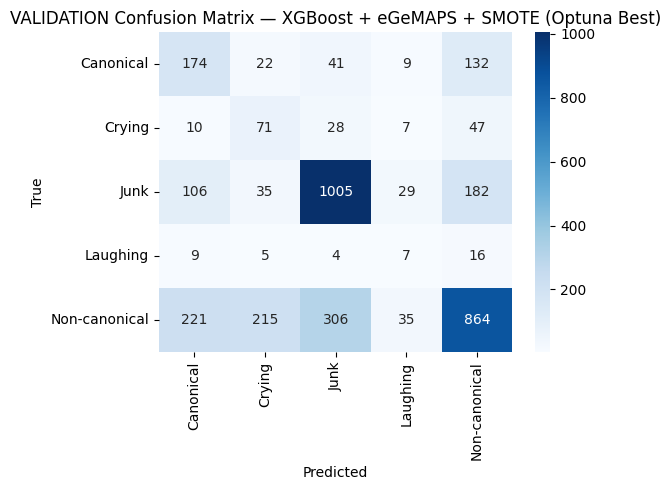

In [34]:
y_valid_pred = final_model.predict(X_valid_egemaps)
metrics_valid = get_classification_score(y_valid_enc, y_valid_pred)

print("\n========== FINAL TEST RESULTS ==========")
print("UAR:", metrics_valid.uar)
print("F1:", metrics_valid.f1_score)
print("Precision:", metrics_valid.precision_score)
print("Recall:", metrics_valid.recall_score)

cm = confusion_matrix(y_valid_enc, y_valid_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("VALIDATION Confusion Matrix — XGBoost + eGeMAPS + SMOTE (Optuna Best)")
plt.tight_layout()


plt.savefig("cm_valid_xgb_egemaps_smote_optuna.png")
plt.show()



========== FINAL TEST RESULTS ==========
UAR: 0.46289987029828944
F1: 0.5938183153226734
Precision: 0.6139462363389586
Recall: 0.5816155988857938


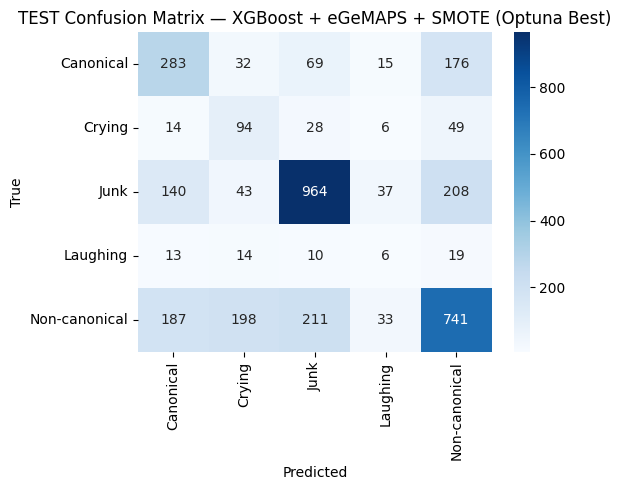

In [35]:
y_test_pred = final_model.predict(X_test_egemaps)
metrics_test = get_classification_score(y_test_enc, y_test_pred)

print("\n========== FINAL TEST RESULTS ==========")
print("UAR:", metrics_test.uar)
print("F1:", metrics_test.f1_score)
print("Precision:", metrics_test.precision_score)
print("Recall:", metrics_test.recall_score)

cm = confusion_matrix(y_test_enc, y_test_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("TEST Confusion Matrix — XGBoost + eGeMAPS + SMOTE (Optuna Best)")
plt.tight_layout()


plt.savefig("cm_test_xgb_egemaps_smote_optuna.png")
plt.show()


In [27]:
run_name = "xgb_egemaps_smote_optuna_best"

with mlflow.start_run(run_name=run_name):

    # Log parameters
    for k, v in best_params.items():
        mlflow.log_param(k, v)

    # Log metrics
    mlflow.log_metric("valid_uar", metrics_valid.uar)
    mlflow.log_metric("valid_f1", metrics_valid.f1_score)
    mlflow.log_metric("valid_precision", metrics_valid.precision_score)
    mlflow.log_metric("valid_recall", metrics_valid.recall_score)
    mlflow.log_metric("test_uar", metrics_test.uar)
    mlflow.log_metric("test_f1", metrics_test.f1_score)
    mlflow.log_metric("test_precision", metrics_test.precision_score)
    mlflow.log_metric("test_recall", metrics_test.recall_score)

    # Log confusion matrix
    mlflow.log_artifact("cm_valid_xgb_egemaps_smote_optuna.png")
    mlflow.log_artifact("cm_test_xgb_egemaps_smote_optuna.png")

    # Log model
    mlflow.sklearn.log_model(final_model, "model")

print("MLflow logging completed.")


2025/12/09 11:17:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/12/09 11:17:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run xgb_egemaps_smote_optuna_best at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/09e3517d0f95442da5f457019312024c.
2025/12/09 11:17:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0.


MLflow logging completed.
